<a href="https://colab.research.google.com/github/Kryptera-K/TEL-Linear-Regression-Flip-Bollinger-Volatility-Breakout-Strategy/blob/main/TEL_Sup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "TEL"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("TEL_clean.csv", index=False)
df

/tmp/ipython-input-3913148573.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2007-06-14,26.908646,27.192624,25.627283,25.627283,662600
2007-06-15,26.874018,27.081806,26.493072,27.081806,1150000
2007-06-18,25.731178,27.081803,25.731178,27.047172,853600
2007-06-19,25.419497,26.112126,25.003917,25.731180,951000
2007-06-20,24.900028,25.509543,24.470599,25.509543,1721800
...,...,...,...,...,...
2025-11-17,234.210007,238.919998,232.490005,236.570007,1855100
2025-11-18,231.539993,233.699997,229.860001,232.990005,2217500
2025-11-19,233.039993,235.830002,230.000000,230.880005,1621300


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BB_PERIOD = 20
BB_SHIFT = 5
BB_STD = 2
LINREG_PERIOD = 14
LINREG_SHIFT = 5
STD_LEVEL = 5
STD_PERIOD = 14
STD_SHIFT = 5
SUPERTREND_MULTIPLIER = 3
SUPERTREND_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

def st_downtrend(df):
    df = calculate_supertrend(df)
    return ~df['SuperTrend']


def calculate_supertrend(df, period=SUPERTREND_PERIOD, multiplier=SUPERTREND_MULTIPLIER):
    """Calculate SuperTrend, Upper Band, and Lower Band"""
    hl2 = (df['High'] + df['Low']) / 2

    # True Range
    tr1 = df['High'] - df['Low']
    tr2 = abs(df['High'] - df['Close'].shift())
    tr3 = abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR
    atr = tr.rolling(period).mean()

    # Basic Bands
    upper_basic = hl2 + multiplier * atr
    lower_basic = hl2 - multiplier * atr

    # Initialize final bands
    upper_band = upper_basic.copy()
    lower_band = lower_basic.copy()

    # SuperTrend list
    supertrend = [True]  # True = Uptrend, False = Downtrend

    for i in range(1, len(df)):
        # Upper Band
        if df['Close'].iloc[i-1] <= upper_band.iloc[i-1]:
            upper_band.iloc[i] = min(upper_basic.iloc[i], upper_band.iloc[i-1])

        # Lower Band
        if df['Close'].iloc[i-1] >= lower_band.iloc[i-1]:
            lower_band.iloc[i] = max(lower_basic.iloc[i], lower_band.iloc[i-1])

        # SuperTrend determination
        if df['Close'].iloc[i] > upper_band.iloc[i-1]:
            supertrend.append(True)
        elif df['Close'].iloc[i] < lower_band.iloc[i-1]:
            supertrend.append(False)
        else:
            supertrend.append(supertrend[-1])

    df['SuperTrend'] = supertrend
    df['Upper_Band'] = upper_band
    df['Lower_Band'] = lower_band

    return df


def open_above_linreg_after_below(df, period=LINREG_PERIOD):
    df = df.copy()
    df['LinReg'] = calculate_linreg(df['Close'], period)
    return (df['Open'] > df['LinReg']) & (df['Open'].shift(1) < df['LinReg'].shift(1))


from sklearn.linear_model import LinearRegression
def calculate_linreg(series, period=LINREG_PERIOD):
    """
    Calculate Linear Regression value for each bar.
    """
    linreg_values = [np.nan] * len(series)
    for i in range(period - 1, len(series)):
        y = series[i - period + 1:i + 1].values.reshape(-1, 1)
        x = np.arange(period).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        linreg_values[i] = model.predict([[period - 1]])[0][0]
    return pd.Series(linreg_values, index=series.index)


def bb_open_below_lower_after_above(df, period=BB_PERIOD, std_multiplier=BB_STD, shift=BB_SHIFT):
    df = calculate_bollinger_bands(df, period, std_multiplier)
    return (df['Open'] < df['BB_Lower']) & (df['Open'].shift(shift) > df['BB_Lower'].shift(shift))


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df


def std_change_up(df):
    df = calculate_std(df)
    return df['STD_Change'] > 0


def calculate_std(df, period=STD_PERIOD):
    """Calculate rolling standard deviation and its change"""
    df['STD'] = df['Close'].rolling(period).std()
    df['STD_Change'] = df['STD'].diff()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Supertrend_DownTrend"] = st_downtrend(df)
df["LinReg_Open_Above_After_Below"] = open_above_linreg_after_below(df)

# -------------------------
# Exit conditions
# -------------------------

df["BB_Open_Below_Lower_after_Above"] = bb_open_below_lower_after_above(df)
df["STD_Change_Up"] = std_change_up(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Supertrend_DownTrend',
    'LinReg_Open_Above_After_Below',
]
exit_conditions = [
    'BB_Open_Below_Lower_after_Above',
    'STD_Change_Up',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                 2007-06-14 00:00:00
End                                   2025-11-21 00:00:00
Period                                 4642 days 00:00:00
Start Value                                      100000.0
End Value                                   1095187.02252
Total Return [%]                               995.187023
Benchmark Return [%]                           735.827975
Max Gross Exposure [%]                              100.0
Total Fees Paid                              36480.877308
Max Drawdown [%]                                82.406916
Max Drawdown Duration                  1239 days 00:00:00
Total Trades                                           63
Total Closed Trades                                    62
Total Open Trades                                       1
Open Trade PnL                              481596.468356
Win Rate [%]                                         50.0
Best Trade [%]                                  113.98636
Worst Trade [%

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2007-06-14 00:00:00
End                           2025-11-21 00:00:00
Period                         4642 days 00:00:00
Start Value                              100000.0
End Value                           835827.975349
Total Return [%]                       735.827975
Benchmark Return [%]                   735.827975
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        80.723573
Max Drawdown Duration           869 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      735827.975349
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1085550275.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


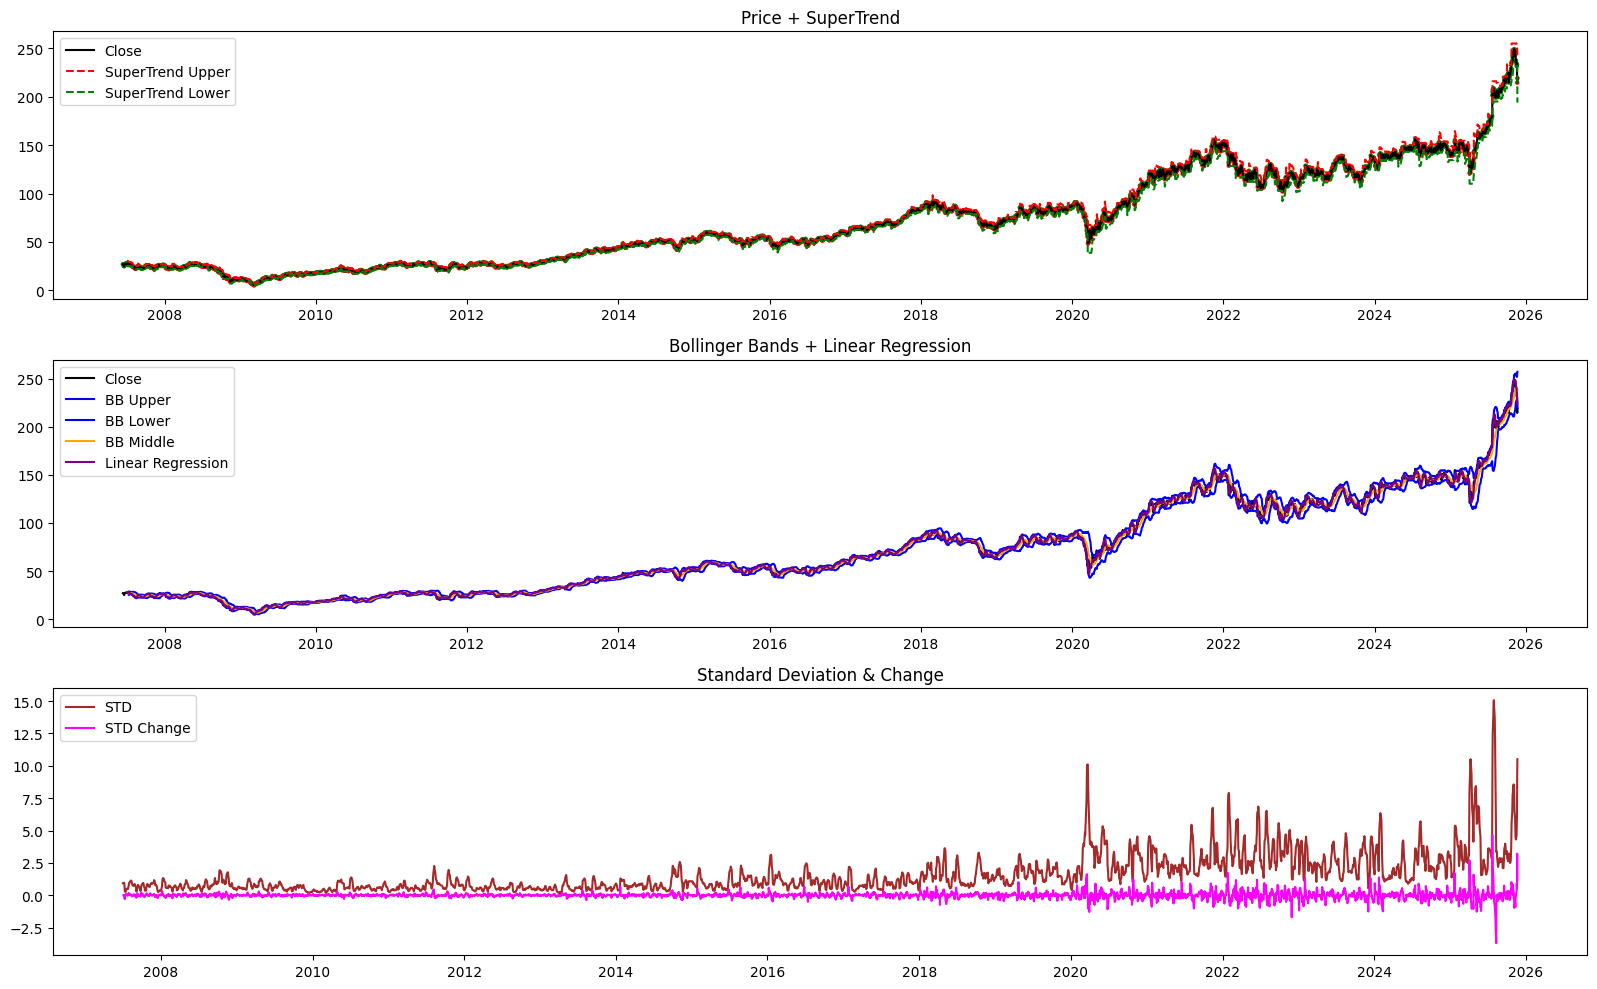

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Download Data
# -------------------------------------------------------------------

symbol = "TEL"
start_date = "2000-01-01"
end_date = "2026-01-01"

df = yf.download(symbol, start=start_date, end=end_date, interval="1d", multi_level_index=False)

# -------------------------------------------------------------------
# REUSE YOUR EXISTING FUNCTIONS
# -------------------------------------------------------------------

# === SuperTrend ===
def calculate_supertrend(df, period=14, multiplier=3):
    hl2 = (df['High'] + df['Low']) / 2

    tr1 = df['High'] - df['Low']
    tr2 = abs(df['High'] - df['Close'].shift())
    tr3 = abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = tr.rolling(period).mean()

    upper_basic = hl2 + multiplier * atr
    lower_basic = hl2 - multiplier * atr

    upper_band = upper_basic.copy()
    lower_band = lower_basic.copy()

    supertrend = [True]

    for i in range(1, len(df)):
        if df['Close'].iloc[i-1] <= upper_band.iloc[i-1]:
            upper_band.iloc[i] = min(upper_basic.iloc[i], upper_band.iloc[i-1])
        if df['Close'].iloc[i-1] >= lower_band.iloc[i-1]:
            lower_band.iloc[i] = max(lower_basic.iloc[i], lower_band.iloc[i-1])

        if df['Close'].iloc[i] > upper_band.iloc[i-1]:
            supertrend.append(True)
        elif df['Close'].iloc[i] < lower_band.iloc[i-1]:
            supertrend.append(False)
        else:
            supertrend.append(supertrend[-1])

    df['SuperTrend'] = supertrend
    df['Upper_Band'] = upper_band
    df['Lower_Band'] = lower_band
    return df


# === Bollinger Bands ===
def calculate_bollinger_bands(df, period=20, std_multiplier=2):
    df['BB_MA'] = df['Close'].rolling(period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(period).std()
    return df


# === Linear Regression ===
from sklearn.linear_model import LinearRegression

def calculate_linreg(series, period=14):
    linreg_values = [np.nan] * len(series)
    for i in range(period - 1, len(series)):
        y = series[i - period + 1:i + 1].values.reshape(-1, 1)
        x = np.arange(period).reshape(-1, 1)
        model = LinearRegression().fit(x, y)
        linreg_values[i] = model.predict([[period - 1]])[0][0]
    return pd.Series(linreg_values, index=series.index)


# === Standard Deviation ===
def calculate_std(df, period=14):
    df['STD'] = df['Close'].rolling(period).std()
    df['STD_Change'] = df['STD'].diff()
    return df


# -------------------------------------------------------------------
# CALCULATE INDICATORS
# -------------------------------------------------------------------
df = calculate_supertrend(df)
df = calculate_bollinger_bands(df)
df['LinReg'] = calculate_linreg(df['Close'])
df = calculate_std(df)

# -------------------------------------------------------------------
# PLOTTING
# -------------------------------------------------------------------

plt.figure(figsize=(16, 10))

# --------------------------
# PRICE + SUPERTREND
# --------------------------
plt.subplot(3, 1, 1)
plt.plot(df['Close'], label='Close', color='black')
plt.plot(df['Upper_Band'], label='SuperTrend Upper', color='red', linestyle='dashed')
plt.plot(df['Lower_Band'], label='SuperTrend Lower', color='green', linestyle='dashed')

plt.scatter(df.index, df['Close'], c=df['SuperTrend'].map({True: 'green', False: 'red'}), s=5)
plt.title("Price + SuperTrend")
plt.legend()

# --------------------------
# BOLLINGER BANDS + LINREG
# --------------------------
plt.subplot(3, 1, 2)
plt.plot(df['Close'], label='Close', color='black')
plt.plot(df['BB_Upper'], label='BB Upper', color='blue')
plt.plot(df['BB_Lower'], label='BB Lower', color='blue')
plt.plot(df['BB_MA'], label='BB Middle', color='orange')
plt.plot(df['LinReg'], label='Linear Regression', color='purple')

plt.title("Bollinger Bands + Linear Regression")
plt.legend()

# --------------------------
# STD + STD CHANGE
# --------------------------
plt.subplot(3, 1, 3)
plt.plot(df['STD'], label="STD", color='brown')
plt.plot(df['STD_Change'], label="STD Change", color='magenta')

plt.title("Standard Deviation & Change")
plt.legend()

plt.tight_layout()
plt.show()
